In [ ]:
!pip install pennylane
#!pip install pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 42.1 MB/s eta 0:00:00


In [ ]:
!pip install catalyst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.7/446.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.4 MB/s eta 0:00:00


In [ ]:
import catalyst
#from catalyst import qjit

import jax.numpy as jnp

In [ ]:

import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [ ]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    vals, vecs = np.linalg.eigh(H_matrix)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    #E_collect=[0,0,0]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    #Stop=[False,False,False]

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if np.abs(Sz) < 1e-5 and vec_check(vec[:,i],elec_num):
            print('The first excied state energy with sz=0:',eng[i])
            #Stop[0]=True
            #E_collect[1]=eng[i]
            E_collect.append(eng[i])
            k+=1
        if k==2:
            break
        #elif np.abs(Sz-1) < 1e-5 and vec_check(vec[:,i],elec_num):
        #    print('The first excied state energy with sz=1:',eng[i])
        #    Stop[1]=True
        #    E_collect[2]=eng[i]
        #elif np.abs(Sz+1) < 1e-5 and vec_check(vec[:,i],elec_num):
        #    print('The first excied state energy with sz=-1:',eng[i])
        #    Stop[2]=True
        #    E_collect[3]=eng[i]
        #if np.all(Stop):
        #    break
    return E_collect


Using exact diagonalization to get the ground state and first excited state.

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5]
E_dict={}
E_0__lst=[]
E_1__lst=[]
E_2__lst=[]
#E_3=[]
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    E0,E1,E2=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)
    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)
    #E_3.append(E3)

The ground state energy with sz=0: -7.047909872435885
The first excied state energy with sz=0: -7.0047253505073765
The first excied state energy with sz=0: -6.98655158630334
The ground state energy with sz=0: -7.784021324750156
The first excied state energy with sz=0: -7.658342766396849
The first excied state energy with sz=0: -7.643809651162728
The ground state energy with sz=0: -7.8821399725735946
The first excied state energy with sz=0: -7.759969497124919
The first excied state energy with sz=0: -7.743624936624291
The ground state energy with sz=0: -7.860828281841008
The first excied state energy with sz=0: -7.775551605885374
The first excied state energy with sz=0: -7.752282360954601
The ground state energy with sz=0: -7.823426970817585
The first excied state energy with sz=0: -7.777598560023309
The first excied state energy with sz=0: -7.741012762416147
The ground state energy with sz=0: -7.798504254068343
The first excied state energy with sz=0: -7.779419938527358
The first excie

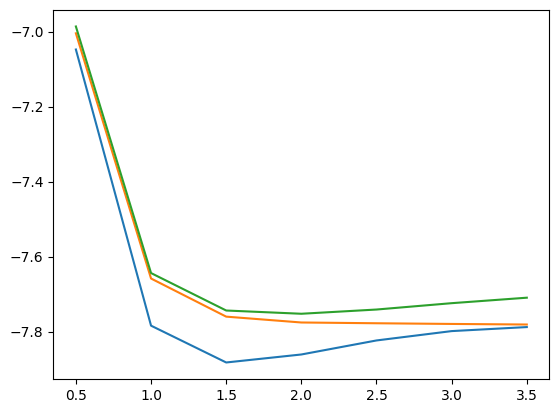

In [ ]:
plt.plot(r_lst,E_0__lst)
plt.plot(r_lst,E_1__lst)
plt.plot(r_lst,E_2__lst)
#plt.plot(r_lst,E_3)
#plt.plot(r_lst,E0_lst)

#plt.plot(r_lst,E1_lst)

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class SS_vqe_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))
        H_matrix=qml.matrix(self.hamiltonian)

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)


    def circuit_sz(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def cost_fn(self,params):
        cost=0
        for ind, stat in enumerate(self.state_lst):
            cost+=self.w[ind]*self.cost_h_fn(stat,params)
        return cost

    def run(self,w=None,epochs=400,stepsize=0.5,num_layer=2,cov=1e-5,print_train=True):
        if w==None:
            self.w=[1.0]+(len(self.state_lst)-1)*[0.5]
        else:
            self.w=w

        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(num_layer*len(self.doubles + self.singles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0
        self.best_weights=self.weights

        cov=cov
        E_pev=[0.0]*len(self.state_lst)
        E_lst=[0.0]*len(self.state_lst)
        E_pev=np.array(E_pev)
        E_lst=np.array(E_lst)
        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)
            for j,stat in enumerate(self.state_lst):
                E_lst[j]=self.cost_h_fn(stat,self.weights)

            if Lowest_cost>cost:
                Lowest_cost=cost
                self.best_weights=self.weights
            cost_val.append(E_lst)

            i=i+1
            if print_train:
                print('iter:',i)
                for j,stat in enumerate(self.state_lst):
                    print(' E0:',E_lst[j],' Sz:',self.Sz_fn(stat,self.weights))
            E_diff=np.abs(E_lst-E_pev)
            if np.all(E_diff<cov):
                break

            #for k in range(len(self.state_lst)):
            E_pev=E_lst.copy()
        self.E_lst=E_lst
        return E_lst

# For Sz=0, finding the three lowest energy using SS-VQE

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5] # the bond length in atomic unit
E_dict={}

E0_lst=[]
E1_lst=[]
E2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    g_stat={'1100000000': 1}
    e_stat_0={'1001000000': 1, '0110000000': -1}
    e_stat_1={'1001000000': 1, '0110000000': 1}

    stat_lst=[g_stat,e_stat_0,e_stat_1]
    ss_vqe=SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))
    E0,E1,E2=ss_vqe.run(epochs=400,num_layer=3)
    E0_lst.append(E0)
    E1_lst.append(E1)
    E2_lst.append(E2)


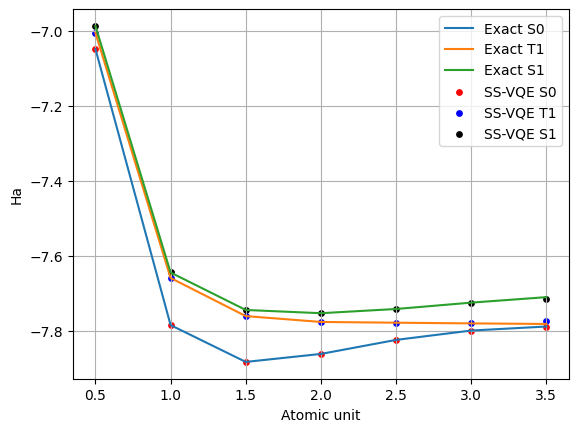

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact S1')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='SS-VQE S0')
plt.scatter(r_lst,E2_lst,s=15,c='b',label='SS-VQE T1')
plt.scatter(r_lst,E1_lst,s=15,c='k',label='SS-VQE S1')

plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
Rel0=np.abs(np.array(E_0__lst)-np.array(E0_lst))/np.abs(np.array(E_0__lst))
Rel1=np.abs(np.array(E_2__lst)-np.array(E2_lst))/np.abs(np.array(E_2__lst))
Rel2=np.abs(np.array(E_1__lst)-np.array(E1_lst))/np.abs(np.array(E_1__lst))

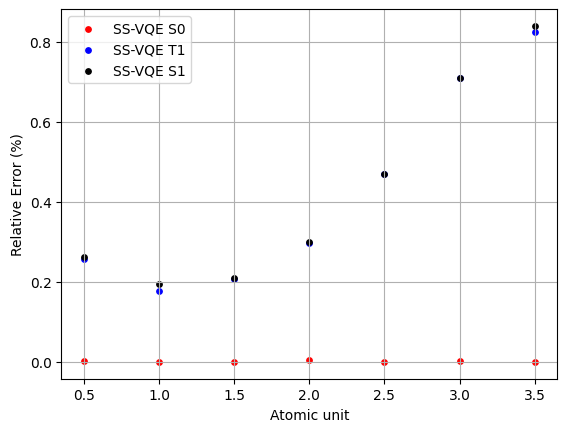

In [ ]:
plt.scatter(r_lst,Rel0*100,s=15,c='r',label='SS-VQE S0')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='SS-VQE T1')
plt.scatter(r_lst,Rel2*100,s=15,c='k',label='SS-VQE S1')

plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()

# For Sz=1, finding the three lowest energy using SS-VQE

In [ ]:
def exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge):

    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.01*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    #E_collect=[0,0,0]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    #Stop=[False,False,False]

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz.real-1)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The energy state:',(eng[i]-0.01*Sz).real,' with Sz=',round(Sz.real,3))

            E_collect.append((eng[i]-0.01*Sz).real)
            k+=1
        if k==2:
            break

    return E_collect

In [ ]:
E_dict={}

E_0__lst=[]
E_1__lst=[]
E_2__lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    E0,E1,E2=exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge)

    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)

The ground state energy with sz=0: -7.047909872435877
The energy state: -7.00472535050736  with Sz= 1.0
The energy state: -6.9679100583105935  with Sz= 1.0
The ground state energy with sz=0: -7.7840213247501415
The energy state: -7.658342766396839  with Sz= 1.0
The energy state: -7.618067684104337  with Sz= 1.0
The ground state energy with sz=0: -7.882139972573577
The energy state: -7.759969497124903  with Sz= 1.0
The energy state: -7.712332320957347  with Sz= 1.0
The ground state energy with sz=0: -7.8608282818410204
The energy state: -7.775551605885385  with Sz= 1.0
The energy state: -7.716045218289305  with Sz= 1.0
The ground state energy with sz=0: -7.823426970817585
The energy state: -7.7775985600233035  with Sz= 1.0
The energy state: -7.707189769957235  with Sz= 1.0
The ground state energy with sz=0: -7.798504254068346
The energy state: -7.779419938527359  with Sz= 1.0
The energy state: -7.701092978024177  with Sz= 1.0
The ground state energy with sz=0: -7.790964266299491
The ene

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5] # the bond length in atomic unit
E_dict={}

E0_lst=[]
E1_lst=[]
#E2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    g_stat={'1010000000': 1}
    e_stat_0={'1000100000': 1}

    stat_lst=[g_stat,e_stat_0]
    ss_vqe=SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))

    E0,E1=ss_vqe.run(epochs=400,num_layer=3)
    E0_lst.append(E0)
    E1_lst.append(E1)
    #E2_lst.append(E2)


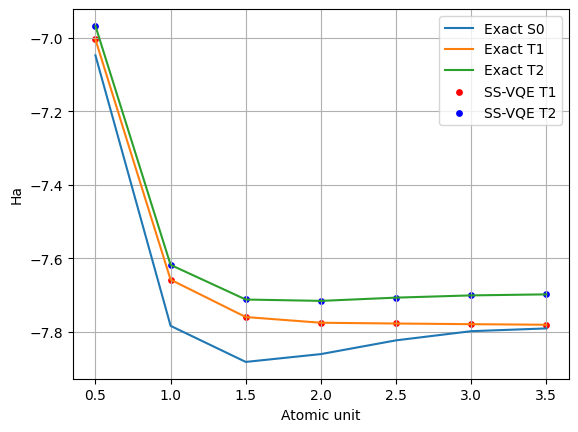

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact T2')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='SS-VQE T1')
plt.scatter(r_lst,E1_lst,s=15,c='b',label='SS-VQE T2')
plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
Rel0=np.abs(np.array(E_1__lst)-np.array(E0_lst))/np.abs(np.array(E_1__lst))
Rel1=np.abs(np.array(E_2__lst)-np.array(E1_lst))/np.abs(np.array(E_2__lst))


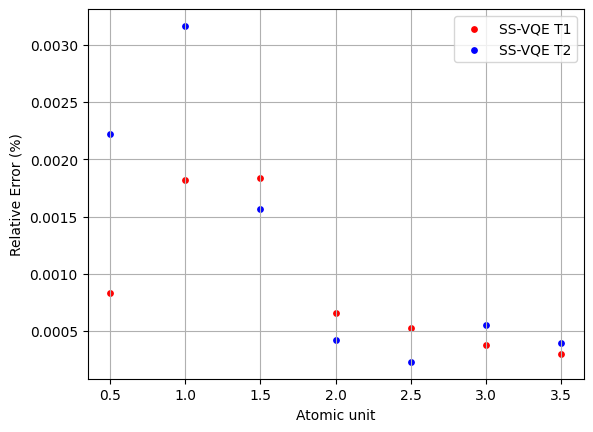

In [ ]:
plt.scatter(r_lst,Rel0*100,s=15,c='r',label='SS-VQE T1')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='SS-VQE T2')


plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class adapt_SS_vqe_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        self.pool_operators=self.singles+self.doubles
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights,ops_cir):
        qml.StatePrep(state, wires=range(self.num_qubits))
        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(weights[i], wires=excitation)
            else:
                qml.SingleExcitation(weights[i], wires=excitation)
        return qml.expval(self.hamiltonian)

    def circuit_sz(self,state,weights,ops_cir):
        qml.StatePrep(state, wires=range(self.num_qubits))
        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(weights[i], wires=excitation)
            else:
                qml.SingleExcitation(weights[i], wires=excitation)
        return qml.expval(self.sz)

    def cost_fn(self,params,ops_cir):
        cost=0
        for ind, stat in enumerate(self.state_lst):
            cost+=self.w[ind]*self.cost_h_fn(stat,params,ops_cir)
        return cost

    def run(self,w=None,epochs=400,stepsize=0.5,cov=1e-6,print_train=True,ep=30,threshold=0.03):
        if w==None:
            self.w=[1.0]+(len(self.state_lst)-1)*[0.5]
        else:
            self.w=w

        opt = qml.GradientDescentOptimizer(stepsize=stepsize)
        self.ops_cir=[]# doubles_select+singles_select
        weights = []
        self.weights=np.array(weights)

        circuit_gradient = qml.grad(self.cost_fn, argnum=0)
        for ind, stat in enumerate(self.state_lst):
            E0 = self.cost_h_fn(stat,self.weights, self.ops_cir)
            print(f"Epoch = 0, Energy = {E0:.8f} Ha")

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0
        #self.best_weights=self.weights

        cov=cov
        E_pev=[0.0]*len(self.state_lst)
        E_lst=[0.0]*len(self.state_lst)
        E_pev=np.array(E_pev)
        E_lst=np.array(E_lst)
        for n in range(epochs):

            Test_set=self.ops_cir+self.pool_operators
            Test_params=list(self.weights)+[0.0]*len(self.pool_operators)
            Test_params=np.array(Test_params)

            test_grads = circuit_gradient(Test_params,Test_set)
            test_grads = test_grads[len(self.weights):]
            maxpos = np.argmax(np.abs(test_grads))
            print('Max:', np.abs(test_grads[maxpos]))
            #if n<= ep or np.abs(test_grads[maxpos])<threshold:

            max_op=self.pool_operators[maxpos]
            self.ops_cir.append(max_op)
            self.weights=np.append(self.weights, 0.0)

            self.weights,_ = opt.step(self.cost_fn,self.weights,self.ops_cir)
            iter.append(i)
            cost=self.cost_fn(self.weights,self.ops_cir)
            for j,stat in enumerate(self.state_lst):
                E_lst[j]=self.cost_h_fn(stat,self.weights,self.ops_cir)

            if Lowest_cost>cost:
                Lowest_cost=cost
                self.best_weights=self.weights
            cost_val.append(E_lst)

            i=i+1
            if print_train:
                print('iter:',i)
                for j,stat in enumerate(self.state_lst):
                    print(' E0:',E_lst[j],' Sz:',self.Sz_fn(stat,self.weights,self.ops_cir))
            E_diff=np.abs(E_lst-E_pev)
            if np.all(E_diff<cov):
                break

            #for k in range(len(self.state_lst)):
            E_pev=E_lst.copy()
        self.E_lst=E_lst
        return E_lst

In [ ]:
L=1.5
symbol=["H", "Li"]
geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

charge=0
num_electrons=2
g_stat={'1100000000': 1}
e_stat_0={'0011000000': 1}

stat_lst=[g_stat,e_stat_0]
ss_vqe=SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)

In [ ]:
ss_vqe.run(epochs=400,num_layer=3)

iter: 1
 E0: -7.361921277730847  Sz: 1.0
 E0: -7.234601256902135  Sz: 1.0
iter: 2
 E0: -7.474552169488863  Sz: 1.0000000000000002
 E0: -7.4118044729879555  Sz: 1.0
iter: 3
 E0: -7.503538938855469  Sz: 0.9999999999999998
 E0: -7.44669907883099  Sz: 1.0000000000000002
iter: 4
 E0: -7.427700121861015  Sz: 0.9999999999999998
 E0: -7.397267940842915  Sz: 1.0
iter: 5
 E0: -7.451825317033858  Sz: 1.0
 E0: -7.429437708051411  Sz: 1.0000000000000002
iter: 6
 E0: -7.512299820084716  Sz: 1.0
 E0: -7.475101725528024  Sz: 1.0000000000000002
iter: 7
 E0: -7.509527462279836  Sz: 1.0
 E0: -7.461334743097946  Sz: 1.0
iter: 8
 E0: -7.474212030925141  Sz: 0.9999999999999998
 E0: -7.424133578333611  Sz: 0.9999999999999998
iter: 9
 E0: -7.48021327519506  Sz: 1.0
 E0: -7.430746972046709  Sz: 1.0000000000000004
iter: 10
 E0: -7.512066790189151  Sz: 1.0
 E0: -7.466241106933297  Sz: 1.0
iter: 11
 E0: -7.519657785498286  Sz: 1.0
 E0: -7.48123206757289  Sz: 1.0
iter: 12
 E0: -7.498070248587248  Sz: 1.0
 E0: -7.4

tensor([-7.52286546, -7.482394  ], requires_grad=True)

In [ ]:
L=1.5
symbol=["H", "Li"]
geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

charge=0
num_electrons=2
g_stat={'1100000000': 1}
e_stat_0={'0110000000': 1}

stat_lst=[g_stat,e_stat_0]
adapt_ss_vqe=adapt_SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)
#print('Running '+str(r))


In [ ]:
adapt_ss_vqe.run(stepsize=0.3)

Epoch = 0, Energy = -7.60898166 Ha
Epoch = 0, Energy = -7.48148812 Ha
Max: 0.12296176040542087
iter: 1
 E0: -7.613115712205009  Sz: 0.0
 E0: -7.481488121567159  Sz: 0.0
Max: 0.10115054719897049
iter: 2
 E0: -7.618158532549854  Sz: 0.0
 E0: -7.481488121567159  Sz: 0.0
Max: 0.06498045031026228
iter: 3
 E0: -7.620933692881612  Sz: 0.0
 E0: -7.481488121567159  Sz: 0.0
Max: 0.06499569443719318
iter: 4
 E0: -7.621470680796848  Sz: 0.0
 E0: -7.483958064899199  Sz: 0.0
Max: 0.05653996764117958
iter: 5
 E0: -7.621256673073083  Sz: 0.0
 E0: -7.487970681907895  Sz: 0.0
Max: 0.04178822119035956
iter: 6
 E0: -7.62053667733883  Sz: 0.0
 E0: -7.491991959442407  Sz: 0.0
Max: 0.02851521821251271
iter: 7
 E0: -7.620129344985771  Sz: 2.7755575615628914e-17
 E0: -7.4942124688072544  Sz: 0.0
Max: 0.028146113872238136
iter: 8
 E0: -7.620079410979386  Sz: -2.7755575615628914e-17
 E0: -7.495476522458387  Sz: 0.0
Max: 0.028076615113345135
iter: 9
 E0: -7.62033262771389  Sz: 0.0
 E0: -7.496214040362119  Sz: 0.0

Exception ignored in: <function _xla_gc_callback at 0x788b3310c820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


iter: 181
 E0: -7.520746140075173  Sz: 0.0
 E0: -7.051111438069299  Sz: -2.7755575615628914e-17
Max: 0.13983685812944335
iter: 182
 E0: -7.520597357739692  Sz: 0.0
 E0: -7.381172416051503  Sz: 0.0


KeyboardInterrupt: 